In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

### Set up DRAGONS

In [2]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

import urllib
import shutil
import subprocess

In [3]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

Ginga not installed, use other viewer, or no viewer


In [4]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    mydb = "dragons_for_goats.db" 
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


### F2 imaging -- GS-2015B-Q-46-59

In [5]:
data_path = "/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM"
obsid = 'GS-2015B-Q-46-59'  
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)

directory for dragons reduction created
Current working directory is: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/dragons_for_goats.db
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/dragonsrc


In [6]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 

## verify what cal db is loaded
cal_service.load_config()
print (cal_service.get_db_path_from_config())

2024-05-09 12:15:31 STDINFO  - Local database file /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/dragons_for_goats.db does not exist. Initializing.
Local database file /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/dragons_for_goats.db does not exist. Initializing.


/home/msoraisam/Desktop/DRAGONS/science_verification/my_drgsv/21tdu.db


**Note above that the `cal_service` has loaded a different database than the one we have specified above `dragons_for_goats.db` for this program. This is because the `cal_service` is reading the databse name from the default dragons config file and not the one we have specificed above. However, we can input the correct config file while calling reduce as shown below.** 

### Generate filelist for the data reduction

In [7]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    cal_file_tags = ['BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','FRINGE'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    meta_keys = cal_file_tags + ['BPM','standard','object', 'unknown']
    all_meta = {}

    for K in meta_keys:
        all_meta[K] = {'file':[],
                        'group_id':[],
                        'exp':[],
                        'objname':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        K = "unknown"
        if "BPM" in ad.tags:
            K = "BPM"
        elif "PREPARED" in ad.tags:
            continue
        elif ("STANDARD" in ad.tags or ad.observation_class()=="partnerCal" or ad.observation_class()=="progCal") and ("UNPREPARED" in ad.tags) and (ad.observation_type()=="OBJECT"):
            K = "standard"            
        elif "CAL" in ad.tags and "UNPREPARED" in ad.tags:
            for tag in cal_file_tags:
                if tag in ad.tags:
                    K = tag
        elif ad.observation_class()=="science" and "UNPREPARED" in ad.tags:
            K = "object"
            
        all_meta[K]['file'].append(F)
        # group_id seems to be not implemented for GNIRS yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['objname'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [8]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}") 

The total number of files for observation ID GS-2015B-Q-46-59 is 235
There are 47 files for observation type DARK
There are 32 files for observation type FLAT
There are 6 files for observation type standard
There are 150 files for observation type object


In [9]:
## extract all_meta into pandas datafrmaes
DF_dark = pd.DataFrame(all_meta['DARK'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_object = pd.DataFrame(all_meta['object'])
DF_standard = pd.DataFrame(all_meta['standard'])


In [10]:
print (f"There are {len(np.unique(DF_object['objname'].values))} science targets in this observation set, namely {np.unique(DF_object['objname'].values)}")

There are 1 science targets in this observation set, namely ['NGC 2244']


**Bad pixel mask (BPM) for F2 imaging is created during reduction, unlike other instrument modes where BPMs are pre-built and available directly from the archive. To build the BPM for F2, it needs "short" dark frames BUT those frames are NOT available as "associated calibrations" on GOA. What this means is, when we download files for the F2 observation ID from the GOATS frontend, the short darks are not downloaded.**

**To download appropriate short dark frames, we need to look up the date of observation. A possible solution is, when listing the DRAGONS reduction plan for a given F2 imaging observation ID on GOATS, a user is shown the option to download the appropriate short darks.**  

In [11]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), f"for this sequence of observations for the science target, minimum date of observation is {min(V['date'])} and maximum date is {max(V['date'])}")

GS-2015B-Q-46-59_H_f/16_G5830_13.0_1_['[1:2048,1:2048]'] 128 for this sequence of observations for the science target, minimum date of observation is 2015-11-28 and maximum date is 2015-11-28
GS-2015B-Q-46-59_Ks_f/16_G5830_15.0_1_['[1:2048,1:2048]'] 22 for this sequence of observations for the science target, minimum date of observation is 2015-11-28 and maximum date is 2015-11-28


**Now download the "appropriate" short (exposure time = 2 sec) darks**

In [12]:
mindate = min(DF_object['date'])
maxdate = max(DF_object['date'])
print (f"for this sequence of observations for the science target, minimum date of observation is {mindate} and maximum date is {maxdate}")


for this sequence of observations for the science target, minimum date of observation is 2015-11-28 and maximum date is 2015-11-28


In [13]:
## Let's relax min and max dates by one day each for the search

mindate = mindate - datetime.timedelta(days=1)
maxdate = maxdate + datetime.timedelta(days=1)

print (str(mindate), str(maxdate))

url = f"https://archive.gemini.edu/download/not_site_monitoring/cols=CTOWBEQ/imaging/{str(mindate).replace('-','')}-{str(maxdate).replace('-','')}/F2/notengineering/DARK/exposure_time=2/NotFail"
tar_local = Path(f"{data_path}/{obsid}").as_posix() + "/f2.tar"
print(f"Short darks to build BPMs for observation ID {obsid} will be stored here {tar_local}")


2015-11-27 2015-11-29
Short darks to build BPMs for observation ID GS-2015B-Q-46-59 will be stored here /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/f2.tar


In [43]:
# Download the files
with urllib.request.urlopen(url) as response:
    with open(tar_local, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

# untar the file
shutil.unpack_archive(tar_local, Path(tar_local).parent) # destination is the parent directory of the tar (see above)
os.remove(tar_local)

print (f"Download of {tar_local} completed")

Download of /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/f2.tar completed


In [44]:
# Let's decompress the downloaded files
subp = subprocess.Popen(('bunzip2 {0}'.format(str(Path(tar_local).parent) + '/*.bz2')), shell=True).communicate()[0]
print (f"Downloaded fits files decompressed")

Downloaded fits files decompressed


In [14]:
# Let's make a pandas dataframe containing just these new short darks

all_files = [str(pp) for pp in list(Path(data_path+"/"+obsid).glob('*.fits'))]
all_files.sort()
DF_short_dark = dataselect.select_data(
    all_files,
    ['F2', 'DARK', 'RAW'],
    [],
    dataselect.expr_parser('exposure_time==2')
)

DF_short_dark

['/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0511.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0512.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0513.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0514.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0515.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0516.fits',
 '/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0517.fits']

## Based on the **observation type** we see above for this data set, we can come up with the full reduction plan. 
## process dark -> create BPM -> process flat -> process standard -> process science
**Note that it is important to start with process dark for F2 imaging to be generic and catch outlier case like the following. The step "create BPM" requires both short-darks and flats. For F2 imaging in Y, J, and H bands, both lamp-on and lamp-off flats are taken, which allow "create BPM" to NOT require a master dark frame (output from "process dark") -- it uses the lamp-off flats for this purpose. However, for K-band, only lamp-off flats are taken, which already has signal from the thermal emission and to remove the dark current, proper darks (when I say proper darks, I mean same exposure time as the flats) are required to remove the dark current in the flats. Here, the master dark from the "process dark" step needs to be used, so this step needs to precede "create BPM", while for the rest of the other filters it doesn't matter which one precedes.**   

And a comment from Kathleen (just putting this here for myself): """...However, you could argue that if all the darks are processed ahead of time, the BPM recipe could just use the already processed dark. But it probably would not associate anyway since they are “short dark” just the shortest dark that could be found in that time period...""" 

In [15]:
logutils.config(file_name='f2_data_reduction.log') # logger

In [19]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None, config_file=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    config_file : str
        full path of the dragons config file to use 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
    if config_file is not None:
        reduce.config_file = config_file
    print (f"Showing primitives of the recipe to be used:\n {showprims(filelist[0])}")
    reduce.runr()
    return reduce

### Process dark

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0511.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0517.fits, 7 files submitted.


(2.0,) 7
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedDark) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0511.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'AZEL_TARGET', 'RAW', 'F2', 'DARK']
Input mode: sq
Input recipe: makeProcessedDark
Matched recipe: geminidr.f2.recipes.sq.recipes_DARK::makeProcessedDark
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_DARK.py
Recipe tags: {'CAL', 'DARK', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.stackDarks()
   p.storeProcessedDark()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
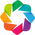

RECIPE: makeProcessedDark
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ----------

(3.0,) 10
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedDark) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151124S0027.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'AZEL_TARGET', 'RAW', 'F2', 'DARK']
Input mode: sq
Input recipe: makeProcessedDark
Matched recipe: geminidr.f2.recipes.sq.recipes_DARK::makeProcessedDark
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_DARK.py
Recipe tags: {'CAL', 'DARK', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.stackDarks()
   p.storeProcessedDark()


RECIPE: makeProcessedDark
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

(8.0,) 10
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedDark) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151121S0107.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'AZEL_TARGET', 'RAW', 'F2', 'DARK']
Input mode: sq
Input recipe: makeProcessedDark
Matched recipe: geminidr.f2.recipes.sq.recipes_DARK::makeProcessedDark
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_DARK.py
Recipe tags: {'CAL', 'DARK', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.stackDarks()
   p.storeProcessedDark()


RECIPE: makeProcessedDark
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

(13.0,) 10
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedDark) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0613.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'AZEL_TARGET', 'RAW', 'F2', 'DARK']
Input mode: sq
Input recipe: makeProcessedDark
Matched recipe: geminidr.f2.recipes.sq.recipes_DARK::makeProcessedDark
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_DARK.py
Recipe tags: {'CAL', 'DARK', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.stackDarks()
   p.storeProcessedDark()


RECIPE: makeProcessedDark
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

(15.0,) 10
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedDark) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0619.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'AZEL_TARGET', 'RAW', 'F2', 'DARK']
Input mode: sq
Input recipe: makeProcessedDark
Matched recipe: geminidr.f2.recipes.sq.recipes_DARK::makeProcessedDark
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_DARK.py
Recipe tags: {'CAL', 'DARK', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.stackDarks()
   p.storeProcessedDark()


RECIPE: makeProcessedDark
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

In [17]:
for K, V in DF_dark.groupby(["exp"]):
    print (K, len(V))
    reduce = dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [18]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='S20151121S0107_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151124S0027_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0511_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0613_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0619_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')


### Create BPM

In [20]:
# creating a BPM using the short darks for each passband/waveband

bpm = {}
for K, V in DF_flat.groupby('waveband'):
    ad = astrodata.open(V['file'].values[0])
    print (K, len(V), "\n")        
    alt_recipe = "makeProcessedBPM"
    reduce = dragons_reduce(list(V['file'].values)+DF_short_dark, alt_recipe, config_file=dragons_rc)
    print (f"Output processed BPM is {reduce.output_filenames[0]}") 
    bpm[K] = reduce.output_filenames[0]


All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0595.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0517.fits, 27 files submitted.


H 20 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0595.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'GCALFLAT', 'GCAL_IR_ON', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'FLAT', 'AZEL_TARGET', 'RAW', 'F2', 'LAMPON', 'IMAGE']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.f2.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'CAL', 'FLAT', 'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.makeLampFlat()
   p.normalizeFlat()
   p.thresholdFlatfield()
   p.storeProcessedFlat()


RECIPE: makeProcessedBPM
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating 

Output processed BPM is S20151128S0595_bpm.fits
K 12 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0607.fits
Input tags: ['LAMPOFF', 'SOUTH', 'AT_ZENITH', 'UNPREPARED', 'GCALFLAT', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'FLAT', 'AZEL_TARGET', 'GCAL_IR_OFF', 'RAW', 'F2', 'IMAGE']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.f2.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'CAL', 'FLAT', 'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.makeLampFlat()
   p.normalizeFlat()
   p.thresholdFlatfield()
   p.storeProces

RECIPE: makeProcessedBPM
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating 

Output processed BPM is S20151128S0607_bpm.fits


In [21]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='S20151121S0107_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151124S0027_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0511_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0613_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0619_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')


**BPMs are not automatically registered in the calibration database, so we have to add them manually.**

In [23]:
for K, V in bpm.items():
    print (K, V)
    caldb.add_cal(V)


# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

H S20151128S0595_bpm.fits
K S20151128S0607_bpm.fits
FileData(name='S20151121S0107_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151124S0027_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0511_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0595_bpm.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction')
FileData(name='S20151128S0607_bpm.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction')
FileData(name='S20151128S0613_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/

### Process flat

In [29]:
for K, V in DF_flat.groupby('waveband'):
    print (K, len(V), "\n")
    ## apparently the exisitng DRAGONS F2 imaging makeProcessedFlat recipe is not able to use the BPM from the caldb. We need to pass it by hand 
    reduce = dragons_reduce(list(V['file'].values), uparams=[('addDQ:user_bpm', bpm[K])] , config_file=dragons_rc)

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0595.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0636.fits, 20 files submitted.


H 20 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0595.fits
Input tags: ['SOUTH', 'AT_ZENITH', 'UNPREPARED', 'GCALFLAT', 'GCAL_IR_ON', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'FLAT', 'AZEL_TARGET', 'RAW', 'F2', 'LAMPON', 'IMAGE']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.f2.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'CAL', 'FLAT', 'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.makeLampFlat()
   p.normalizeFlat()
   p.thresholdFlatfield()
   p.storeProcessedFlat()


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

K 12 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0607.fits
Input tags: ['LAMPOFF', 'SOUTH', 'AT_ZENITH', 'UNPREPARED', 'GCALFLAT', 'CAL', 'GEMINI', 'NON_SIDEREAL', 'FLAT', 'AZEL_TARGET', 'GCAL_IR_OFF', 'RAW', 'F2', 'IMAGE']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.f2.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'CAL', 'FLAT', 'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.addVAR(read_noise=True)
   p.nonlinearityCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.makeLampFlat()
   p.normalizeFlat()
   p.thresholdFlatfield()
   p.storeProcessedFlat()


RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating

In [30]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='S20151121S0107_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151124S0027_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0511_dark.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_dark')
FileData(name='S20151128S0595_bpm.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction')
FileData(name='S20151128S0595_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/calibrations/processed_flat')
FileData(name='S20151128S0607_bpm.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015

### Process standard

In [37]:
for K, V in DF_standard.groupby('group_id'):
    print (K, len(V), "\n")        
    ## again the recipe doesn't know how to pick up BPM automatically from the calibration database so we are providing it by hand
    reduce = dragons_reduce(list(V['file'].values), uparams=[('addDQ:user_bpm', bpm[V['waveband'].values[0]])], config_file=dragons_rc)

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0092.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0094.fits, 3 files submitted.


GS-2015B-SV-301-46_H_f/16_G5830_3.0_1_['[1:2048,1:2048]'] 3 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0092.fits
Input tags: ['SOUTH', 'SIDEREAL', 'UNPREPARED', 'RAW', 'F2', 'GEMINI', 'IMAGE']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.f2.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.flushPixels()
   p.separateSky()
   p.associateSky(stream='sky')
   p.skyCorrect(instream='sky', mask_objects=False, outstream='skysub')
   p.detectSources(stream='skysub')
   p.transferAt

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         .
      .
   .
   PRIMITIVE: addDQ
   --

ValueError: Only 2 images but nlow=1 and nhigh=1

**You will see that the above crashes. I'm leaving it as it is because this is a corner case where the user needs to tweak parameters of a given primitive "skyCorrect" in this case.**

In [44]:
pobj, tags = showpars.get_pars(DF_standard['file'].values[0]) # returns the primitive class object and astrodata tags
showpars.showpars(pobj, 'skyCorrect', tags, show_docstring=None)

Dataset tagged as {'SOUTH', 'UNPREPARED', 'GEMINI', 'SIDEREAL', 'RAW', 'F2', 'IMAGE'}

Settable parameters on 'skyCorrect':
Name                 Current setting      Description

suffix               '_skyCorrected'      Filename suffix
reset_sky            False                Replace lost sky counts?
scale_sky            True                 Scale sky frame to science frame?
offset_sky           False                Apply offset to sky frame to match science frame?
sky                  None                 Sky frame to subtract
save_sky             False                Save sky frame to disk?
apply_dq             True                 Use DQ to mask bad pixels?
statsec              None                 Section for statistics
operation            'median'             Averaging operation
Allowed values:
	mean	arithmetic mean
	wtmean	variance-weighted mean
	median	median
	lmedian	low-median

reject_method        'minmax'             Pixel rejection method
Allowed values:
	none	no rejecti

**Let's change the "reject_method" to one of the allowed values that is not "minmax" -- choose "sigclip" -- and run the reduction for the standard star again**

In [45]:
for K, V in DF_standard.groupby('group_id'):
    print (K, len(V), "\n")        
    ## again the recipe doesn't know how to pick up BPM automatically from the calibration database so we are providing it by hand
    reduce = dragons_reduce(list(V['file'].values), uparams=[('addDQ:user_bpm', bpm[V['waveband'].values[0]]), ('skyCorrect:reject_method', 'sigclip')], 
                            config_file=dragons_rc)

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0092.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0094.fits, 3 files submitted.


GS-2015B-SV-301-46_H_f/16_G5830_3.0_1_['[1:2048,1:2048]'] 3 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0092.fits
Input tags: ['SOUTH', 'SIDEREAL', 'UNPREPARED', 'RAW', 'F2', 'GEMINI', 'IMAGE']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.f2.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.flushPixels()
   p.separateSky()
   p.associateSky(stream='sky')
   p.skyCorrect(instream='sky', mask_objects=False, outstream='skysub')
   p.detectSources(stream='skysub')
   p.transferAt

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         .
      .
   .
   PRIMITIVE: addDQ
   --

GS-2015B-SV-301-46_Ks_f/16_G5830_3.0_1_['[1:2048,1:2048]'] 3 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151129S0095.fits
Input tags: ['SOUTH', 'SIDEREAL', 'UNPREPARED', 'RAW', 'F2', 'GEMINI', 'IMAGE']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.f2.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.flushPixels()
   p.separateSky()
   p.associateSky(stream='sky')
   p.skyCorrect(instream='sky', mask_objects=False, outstream='skysub')
   p.detectSources(stream='skysub')
   p.transferA

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         Updating keywords that are specific to FLAMINGOS-2
         .
      .
   .
   PRIMITIVE: addDQ
   --

### Process science

In [ ]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), "\n")        
    ## again the recipe doesn't know how to pick up BPM automatically from the calibration database so we are providing it by hand
    reduce = dragons_reduce(list(V['file'].values), uparams=[('addDQ:user_bpm', bpm[V['waveband'].values[0]])], config_file=dragons_rc)

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0241.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0368.fits, 128 files submitted.


GS-2015B-Q-46-59_H_f/16_G5830_13.0_1_['[1:2048,1:2048]'] 128 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0241.fits
Input tags: ['SOUTH', 'SIDEREAL', 'UNPREPARED', 'RAW', 'F2', 'GEMINI', 'IMAGE']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.f2.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.flushPixels()
   p.separateSky()
   p.associateSky(stream='sky')
   p.skyCorrect(instream='sky', mask_objects=False, outstream='skysub')
   p.detectSources(stream='skysub')
   p.transferA

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: standardizeStructure
         -------------------------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords t

**The NB crashed as it was processing the 128 frames.**  

**Reducing only the K-band data below**

In [53]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), "\n")        
    if len(V) > 100:
        print (f"Skipping this group for {np.unique(V['objname'].values)} for this prototyping\n")
        continue
    ## again the recipe doesn't know how to pick up BPM automatically from the calibration database so we are providing it by hand
    reduce = dragons_reduce(list(V['file'].values), uparams=[('addDQ:user_bpm', bpm[V['waveband'].values[0]])], config_file=dragons_rc)

         All submitted files appear valid:
         /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0369.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0390.fits, 22 files submitted.


GS-2015B-Q-46-59_H_f/16_G5830_13.0_1_['[1:2048,1:2048]'] 128 

Skipping this group for ['NGC 2244'] for this prototyping

GS-2015B-Q-46-59_Ks_f/16_G5830_15.0_1_['[1:2048,1:2048]'] 22 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/S20151128S0369.fits
Input tags: ['SOUTH', 'SIDEREAL', 'UNPREPARED', 'RAW', 'F2', 'GEMINI', 'IMAGE']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.f2.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/f2/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'F2'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.flushPixels()
   p.separateSky()
   p.associateSky(stream='sky')


         RECIPE: reduce
            PRIMITIVE: prepare
            ------------------
               PRIMITIVE: validateData
               -----------------------
               .
               PRIMITIVE: standardizeStructure
               -------------------------------
                  PRIMITIVE: standardizeStructure
                  -------------------------------
                  .
               .
               PRIMITIVE: standardizeHeaders
               -----------------------------
                  PRIMITIVE: standardizeObservatoryHeaders
                  ----------------------------------------
                  Updating keywords that are common to all Gemini data
                  Updating keywords that are common to all Gemini data
                  Updating keywords that are common to all Gemini data
                  Updating keywords that are common to all Gemini data
                  Updating keywords that are common to all Gemini data
                  Updatin

#### See that the final data product is finally present in the reduction folder 

In [54]:
!ls /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/*image.fits

/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/S20151128S0369_image.fits
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/S20151129S0092_image.fits
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/S20151129S0095_image.fits


Filename: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GS-2015B-Q-46-59/reduction/S20151128S0369_image.fits
Tags: F2 GEMINI IMAGE PREPARED PROCESSED PROCESSED_SCIENCE SIDEREAL SOUTH

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (2371, 2474)   float32
          .variance             ADVarianceUncerta (2371, 2474)   float32
          .mask                 ndarray           (2371, 2474)   uint16

Other Extensions
               Type        Dimensions
.PROVENANCE    Table       (25, 4)
.PROVHISTORY   Table       (21, 4)


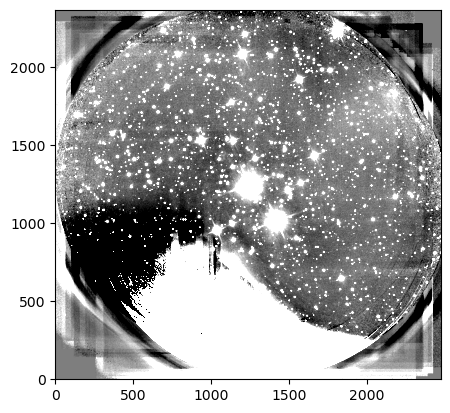

In [57]:
# plotting the reduced K-band image

plt.close('all')
fig, ax = plt.subplots()
ad = astrodata.open(f"{data_path}/{obsid}/reduction/S20151128S0369_image.fits")
ad.info()
ax.imshow(ad[0].data, origin="lower", cmap='grey', vmin=np.percentile(ad[0].data, 10), vmax=np.percentile(ad[0].data, 80))
plt.show()